## VaR for one asset - OU process
This notebook investigates how to estimate parametric Value-at-Risk for a single asset, for one asset, with and without holding period scaling. We start by modelling prices using the Ornstein-Uhlenbeck (OU) process in log-space. The motivation for this is that traditional Geometric Brownian Motion tend toward zero under high volatility. The OU process in contrast in a mean-reverting Gaussian process, allowing us to model prices with high levels of volatility without trending to 0. 

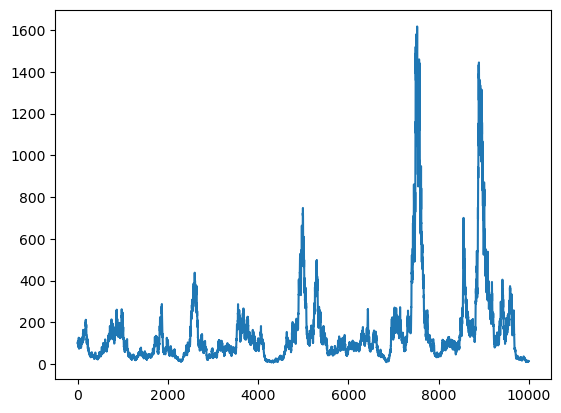

In [110]:
n = 10000
dt = 1/252
kappa = 1.0
theta = np.log(100)
sigma = 1.2

logP = np.zeros(n)
logP[0] = np.log(100)
for t in range(1, n):
    logP[t] = logP[t-1] + kappa*(theta - logP[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()

prices = np.exp(logP)
plt.plot(prices)
plt.show()

From our price series we calculate the simple returns and log returns, and plot the distributions: 

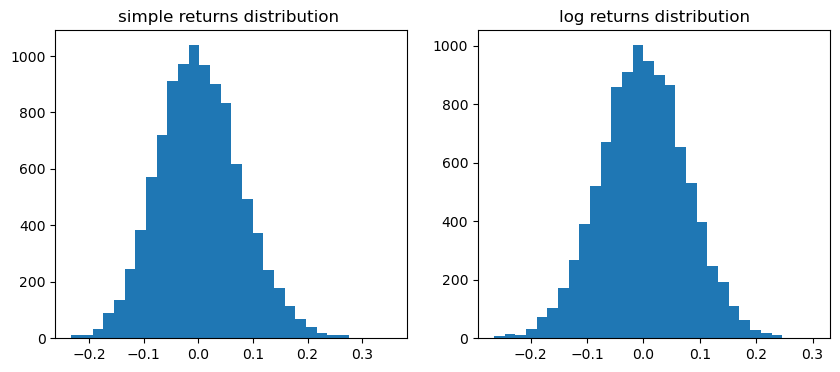

In [111]:
simpleR = prices[1:] / prices[:-1] - 1 
logR = np.log(prices[1:] / prices[:-1])
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(simpleR, bins=30)
axes[0].set_title('simple returns distribution ')
axes[1].hist(logR, bins=30)
axes[1].set_title('log returns distribution')
plt.show()

The simple retunrs distribution has a right tail whereas the log returns distribution is normal:

In [112]:
from scipy.stats import normaltest

stat, p = normaltest(simpleR)
print(f"D’Agostino–Pearson test p-value for simple return distribution (reject normal if p < 0.05): {p:.4f}")
stat, p = normaltest(logR)
print(f"D’Agostino–Pearson test p-value for log return distribution (reject normal if p < 0.05): {p:.4f}")

D’Agostino–Pearson test p-value for simple return distribution (reject normal if p < 0.05): 0.0000
D’Agostino–Pearson test p-value for log return distribution (reject normal if p < 0.05): 0.9679


The empirical VaR estimate based on this history is the 1% quantile of largest losses. The parametric VaR estimates are here calculated in three ways: 1. assuming simple returns are normal, 2.assuming log_returns are normal, 3. assuming log returns are normal and converting VaR estimate back into simple return space. All estimates here are pretty close the exponential approach (lognormal) is closest. 

In [113]:
empirical_VaR = -np.percentile(simpleR, 1)
std_simple = simpleR.std()
std_log = logR.std()

VaR_simple = (2.326 * std_simple)
VaR_log = (2.326 * std_log)
VaR_exp = 1- np.exp(-2.326 * std_log)

print(f"Empirical 99% VaR: {empirical_VaR:.4f}")
print(f"Linear (simple):   {VaR_simple:.4f}")
print(f"Linear (log):      {VaR_log:.4f}")
print(f"Exponential (true):{VaR_exp:.4f}")

Empirical 99% VaR: 0.1630
Linear (simple):   0.1780
Linear (log):      0.1773
Exponential (true):0.1624


Below we calculate the 10-day rolling simple returns and 10-day rolling log returns. We can see from their distributions that compounding efefcts make the simple return distribution more clearly lognormal, while the log return distribution still looks normal. 

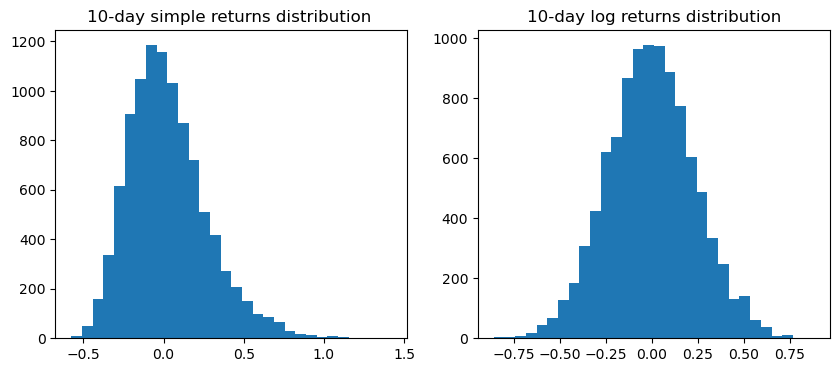

In [114]:
simpleR_df = pd.DataFrame(simpleR)
simpleR_rolling = (1 + simpleR_df).rolling(10).apply(np.prod, raw=True) - 1

logR_df = pd.DataFrame(logR)
logR_rolling = logR_df.rolling(10).sum()

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(simpleR_rolling, bins=30)
axes[0].set_title('10-day simple returns distribution ')
axes[1].hist(logR_rolling, bins=30)
axes[1].set_title('10-day log returns distribution')
plt.show()

Our two first approaches apply linear scaling while the third applies lognormal scaling e^(sqrt(holding_period). The exponential approach is clearly better when VaR estimates are scaled.

In [115]:
empirical_scaled = - simpleR_rolling.dropna().quantile(0.01)

VaR_simple_scaled = (2.326 * std_simple * np.sqrt(10))
VaR_log_scaled = (2.326 * std_log * np.sqrt(10))
VaR_exp_scaled = 1 - np.exp(-2.326 * std_log * np.sqrt(10))

print(f"Empirical 99% 10-day VaR: {empirical_scaled.item():.4f}")
print(f"Linear (simple) scaled:   {VaR_simple_scaled:.4f}")
print(f"Linear (log) scaled:      {VaR_log_scaled:.4f}")
print(f"Exponential (true) scaled:{VaR_exp_scaled:.4f}")

Empirical 99% 10-day VaR: 0.4222
Linear (simple) scaled:   0.5628
Linear (log) scaled:      0.5605
Exponential (true) scaled:0.4291


Here we generate VaR estimates for holding periods from 10 days (two working weeks) to 130 days (6 months worth of working days) and demonstrate how the lognormal (exponential) VaR estimate is closest to the empirical quantile.

In [116]:
simple = []
log = []
exp = []
empirical = [] 

for holding_period in range(10, 131, 10):
    simpleR_rolling = ((1 + simpleR_df).rolling(holding_period).apply(np.prod, raw=True) - 1).dropna()
    logR_rolling = (logR_df.rolling(holding_period).sum()).dropna()
    
    simple.append(2.326 * std_simple * np.sqrt(holding_period))
    log.append(2.326 * std_log * np.sqrt(holding_period))
    exp.append(1 - np.exp(-2.326 * std_log * np.sqrt(holding_period)))
    
    empirical.append(-simpleR_rolling.quantile(0.01).item())
    
VaR_simple_scaled = pd.DataFrame(simple, columns=["VaR_simple"])
VaR_log_scaled = pd.DataFrame(log, columns=['VaR_log'])
VaR_exp_scaled = pd.DataFrame(exp, columns=['VAR_exp'])
empirical = pd.DataFrame(empirical, columns=['VAR_empirical'])

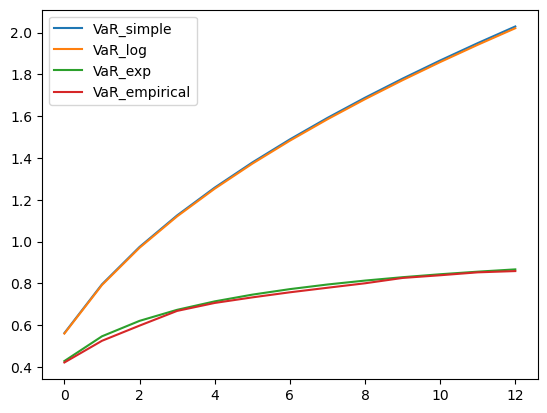

In [117]:
plt.plot(VaR_simple_scaled, label="VaR_simple")
plt.plot(VaR_log_scaled, label="VaR_log")
plt.plot(VaR_exp_scaled, label="VaR_exp")
plt.plot(empirical, label="VaR_empirical")
plt.legend()
plt.show()